# Supervised & Unsupervised Topic Modelling

In [1]:
import arxiv
import string
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/66096149/pyldavis-visualization-from-gensim-not-displaying-the-result-in-google-colab
# newer versions of pyLDAvis do not seem to work with Notebooks, install version 2.1.2 specifically if you're running into errors!
import pyLDAvis.gensim
import warnings
import nltk
from typing import List
from wordcloud import WordCloud
from gensim import models, corpora

try:
    from nltk.corpus import stopwords
except:
    import nltk
    nltk.download('stopwords')
finally:
    from nltk.corpus import stopwords

/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
# constants
sns.set()
warnings.filterwarnings("ignore") # supresses all warnings

queries = [
    'automl', 'machinelearning', 'data', 'phyiscs','mathematics', 'recommendation system', 'nlp', 'neural networks'
]

## Load Data

In [3]:
def search_arxiv(queries: List[str], max_results: int = 100) -> pd.DataFrame:
    '''
    This function will search arxiv associated to a set of queries and store
    the latest 10000 (max_results) associated to that search.
    
    Args:
        queries (List -> Str) : A list of strings containing keywords you want
                                to search on Arxiv
        max_results (Int) : The maximum number of results you want to see associated
                            to your search. Default value is 1000, capped at 300000
                            
    Returns:
        This function will return a DataFrame holding the following columns associated
        to the queries the user has passed. 
            `title`, `date`, `article_id`, `url`, `main_topic`, `all_topics`
    
    Example:
        research_df = search_arxiv(
            queries = ['automl', 'recommender system', 'nlp', 'data science'],
            max_results = 10000
        )
    '''
    d = []
    searches = []
    # hitting the API
    for query in queries:
        search = arxiv.Search(
          query = query,
          max_results = max_results,
          sort_by = arxiv.SortCriterion.SubmittedDate,
          sort_order = arxiv.SortOrder.Descending
        )
        searches.append(search)
    
    # Converting search result into df
    for search in searches:
        for res in search.results():
            data = {
                'title' : res.title,
                'date' : res.published,
                'article_id' : res.entry_id,
                'url' : res.pdf_url,
                'main_topic' : res.primary_category,
                'summary' : res.summary,
                'all_topics' : res.categories,
                'authors' : res.authors
            }
            d.append(data)
        
    d = pd.DataFrame(d)
    d['year'] = pd.DatetimeIndex(d['date']).year
    
    # change article id from url to integer
    unique_article_ids = d.article_id.unique()
    article_mapping = {art:idx for idx,art in enumerate(unique_article_ids)}
    d['article_id'] = d['article_id'].map(article_mapping)
    return d


In [4]:
# fetch data from arXiv
research_df = search_arxiv(
    queries = queries,
    max_results = 100
)
print(research_df.shape)

(648, 9)


In [5]:
research_df.head()

,title,date,article_id,url,main_topic,summary,all_topics,authors,year
0,Open Problems in Applied Deep Learning,2023-01-26 18:55:43+00:00,0,http://arxiv.org/pdf/2301.11316v1,cs.LG,This work formulates the machine learning mech...,"[cs.LG, cs.AI, cs.CV, cs.HC, cs.IR]",[Maziar Raissi],2023
1,RF+clust for Leave-One-Problem-Out Performance...,2023-01-23 16:14:59+00:00,1,http://arxiv.org/pdf/2301.09524v2,cs.NE,Per-instance automated algorithm configuration...,"[cs.NE, cs.AI]","[Ana Nikolikj, Carola Doerr, Tome Eftimov]",2023
2,Improvement of Computational Performance of Ev...,2023-01-12 15:59:04+00:00,2,http://arxiv.org/pdf/2301.05102v1,cs.LG,Resource-intensive computations are a major fa...,"[cs.LG, cs.NE, cs.PF]","[Nikolay O. Nikitin, Sergey Teryoshkin, Valeri...",2023
3,Data-driven photometric redshift estimation fr...,2022-12-30 13:01:41+00:00,3,http://arxiv.org/pdf/2212.14668v1,astro-ph.IM,Redshift measurement has always been a constan...,"[astro-ph.IM, astro-ph.CO]","[Felipe M F de Oliveira, Marcelo Vargas dos Sa...",2022
4,Multi-objective Tree-structured Parzen Estimat...,2022-12-13 17:33:02+00:00,4,http://arxiv.org/pdf/2212.06751v1,cs.LG,Hyperparameter optimization (HPO) is essential...,"[cs.LG, cs.AI]","[Shuhei Watanabe, Noow Awad, Masaki Onishi, Fr...",2022


## Data Cleaning

In [6]:
def remove_stopwords(text: str, sw: List[str] = stopwords.words('english')) -> str:
    '''
    This function will remove stopwords from the text
    
    Args:
        text: String of data you want to remove stopwords from
        sw: List of strings indicating the list of stopwords
        
    Returns:
        The input string with the stopwords removed.
    '''
    additional_sw = ['we', 'the', 'this', 'via', 'using']
    sw = sw + additional_sw
    
    text_list = text.split()
    text_list = [word for word in text_list if word.lower() not in sw]
    return ' '.join(text_list)
    
def remove_punctuation(text: str, punct: str = string.punctuation) -> str:
    '''
    This function will remove punctuations from the text.
    
    Args:
        text: String of data you want to remove punctuations from
        punct: String of punctuations
    
    Returns:
        The input string with the punctuations removed.
    '''
    cleaned_text = ''.join([char for char in text if char not in punct])
    return cleaned_text
    
def unicode(text: str) -> str:
    '''
    This function will make all the data unicoded. Meaning Â -> A
    
    Args:
        text: String of data you want to unicode
    
    Returns:
        The input string unicoded.
    '''
    return unidecode.unidecode(text)
    
def clean(text: str) -> str:
    '''
    This method will clean the input text through unidecoding and stopword and punctuation 
    removal.
    
    Args:
        text: String indicating the body of text you want to clean
    
    Returns:
        A string corresponding to the cleaned version of the input string.
    '''
    text = unicode(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text.lower()

In [7]:
%time research_df['cleaned_summary'] = research_df['summary'].apply(lambda x : clean(x))

CPU times: user 124 ms, sys: 1.74 ms, total: 126 ms
Wall time: 125 ms


In [8]:
research_df['cleaned_summary'].values[0]

'work formulates machine learning mechanism bilevel optimization problem inner level optimization loop entails minimizing properly chosen loss function evaluated training data nothing wellstudied training process pursuit optimal model parameters outer level optimization loop less wellstudied involves maximizing properly chosen performance metric evaluated validation data call iteration process pursuing optimal model hyperparameters among many degrees freedom process entails model engineering eg neural network architecture design management experiment tracking dataset versioning augmentation iteration process could automated automatic machine learning automl left intuitions machine learning students engineers researchers regardless route take need reduce computational cost iteration step direct consequence reduce carbon footprint developing artificial intelligence algorithms despite clean unified mathematical formulation iteration step bilevel optimization problem solutions case specifi

In [9]:
%time research_df['summary_word_count'] = research_df['cleaned_summary'].astype('str').str.count(' ')

CPU times: user 2.61 ms, sys: 100 µs, total: 2.71 ms
Wall time: 2.64 ms


In [10]:
research_df.summary_word_count.describe()

count    648.000000
mean     106.824074
std       36.323975
min       10.000000
25%       82.000000
50%      105.500000
75%      132.000000
max      194.000000
Name: summary_word_count, dtype: float64

648 documents in total
287 documents have fewer than 100 words
44.3% documents have fewer than 100 words


Text(0.5, 0, 'Word_count')

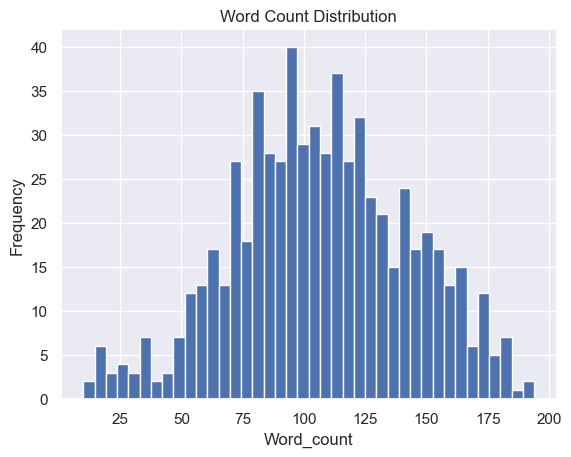

In [11]:
# word count distribution
N = 100
print('{} documents in total'.format(research_df.shape[0]))
print('{} documents have fewer than {N} words'.format(research_df[research_df.summary_word_count<=N].shape[0], N = N))
print('{}% documents have fewer than {N} words'.format(round(research_df[research_df.summary_word_count<=N].shape[0]/research_df.shape[0]*100, 1), N = N))

ax = research_df.summary_word_count.plot.hist(bins=40)
ax.set_title("Word Count Distribution")
ax.set_xlabel('Word_count')

# Unsupervised Learning - LDA

In [12]:
article_summaries = research_df['cleaned_summary'].values
article_summaries = [[word for word in nltk.word_tokenize(article)] for article in article_summaries]

In [13]:
# Create a dictionary of all the words in the dataset
dictionary = corpora.Dictionary(article_summaries)

# Create a corpus
corpus = [dictionary.doc2bow(article) for article in article_summaries]

In [14]:
%%time
# Create an LDA model
lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=20)

CPU times: user 4.63 s, sys: 13.6 ms, total: 4.64 s
Wall time: 4.65 s


In [15]:
# # Get the topic distribution for each document
# for i, article in enumerate(article_summaries[0:10]):
#     print(f"Article {i+1}: {lda.get_document_topics(corpus[i])}")

# # Print the top words for each topic
# print(lda.print_topics())

## Visualization

In [16]:
lda_vis = pyLDAvis.gensim.prepare(
    lda,
    corpus, 
    dictionary=lda.id2word,
    mds='mmds',
    sort_topics=False
)

/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the 

In [17]:
pyLDAvis.display(lda_vis)

## Word Cloud

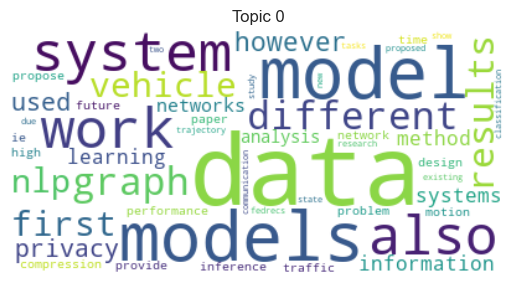

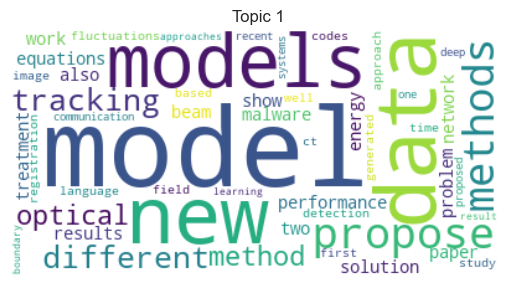

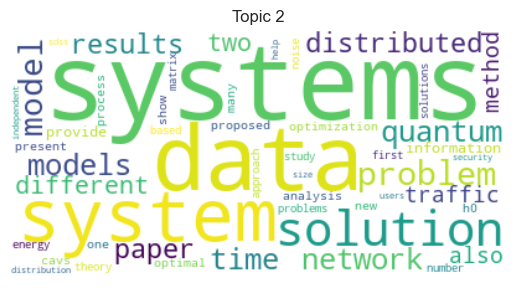

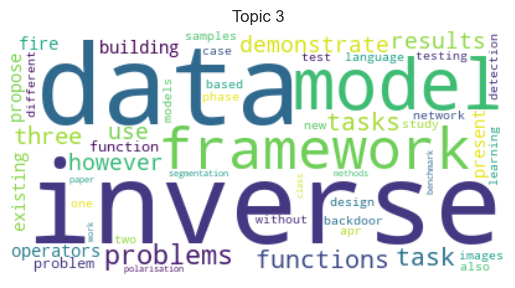

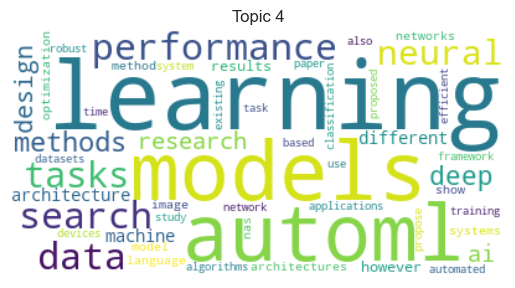

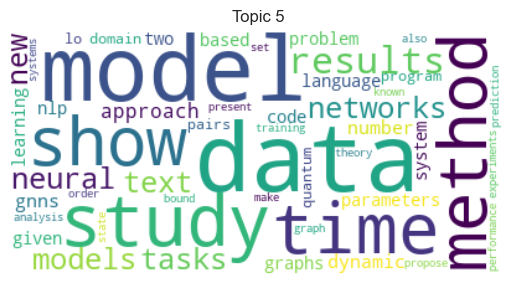

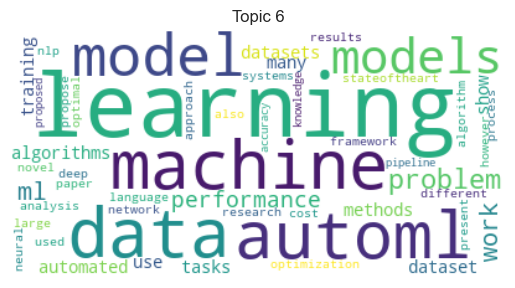

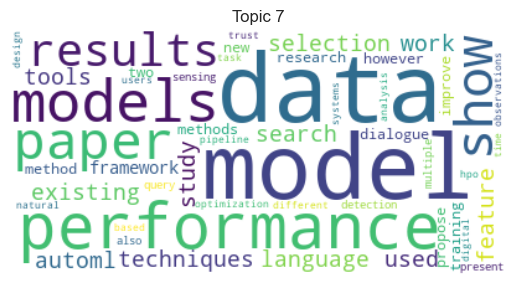

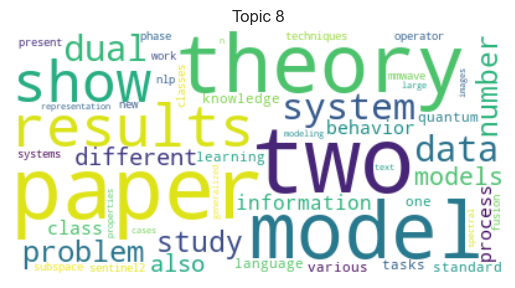

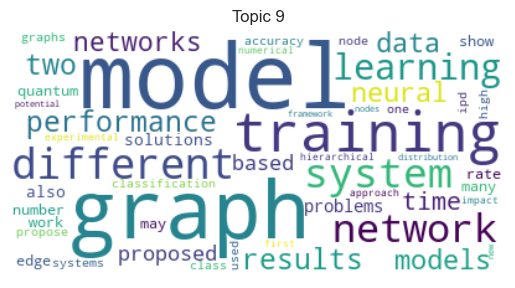

In [18]:
def create_wordcloud(model: models.LdaModel, topic: int):
    '''
    This class will generate a word cloud given an LDA Model and the topic.
    
    Args:
        mdl: LDA Model
        topic: Integer representing the topic
    '''
    text = {word: value for word, value in model.show_topic(topic, topn=50)}
    wc = WordCloud(
        background_color="white",
        max_words=1000
    )
    wc.generate_from_frequencies(text)
    plt.clf()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()
    
for i in range (0,10):
    create_wordcloud(lda, topic=i)

## Topic Analysis

In [19]:
def top_relevant_topics_per_article(mdl: models.LdaModel, corpus: list, articles: list, th: int) -> pd.DataFrame:
    """This method will create a dataframe which identifies the top relevant topics
    greater than a threshold for a given article.
    
    Args:
        mdl: LDA model
        corpus: List of tuples holding the corpus
        articles: List of strings with the article summaries
        th: Integer indicating the threshold of probability the topic must be greater than
    
    Returns:
        A DataFrame with the columns "articl", "topic" and "probability".
    """
    relevant_df = []
    
    for i, article in enumerate(articles):
        topics = mdl.get_document_topics(corpus[i])
        topics = sorted(topics, key = lambda x : x[1], reverse = True)[:5]
        for topic in topics:
            proba = topic[1]
            if proba > th:
                data = {
                    "article" : article,
                    "topic" : topic[0],
                    "proba" : proba
                }
                relevant_df.append(pd.DataFrame([data]))
    return pd.concat(relevant_df)

In [20]:
th = 0.3
articles = [' '.join(article) for article in article_summaries]
rel_df = top_relevant_topics_per_article(lda, corpus, articles, th)

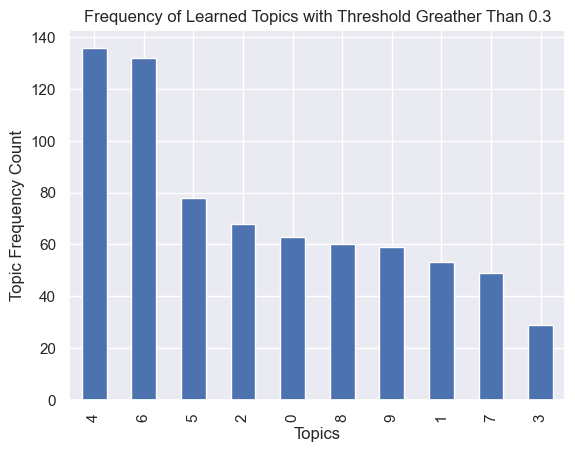

In [21]:
plt.clf()
rel_df['topic'].value_counts().plot(kind = 'bar')
plt.xlabel("Topics")
plt.ylabel("Topic Frequency Count")
plt.title("Frequency of Learned Topics with Threshold Greather Than {th}".format(th=th))
plt.show()

In [22]:
list_sorted_token = sorted(lda.id2word.cfs.items(), key=lambda item: item[1], reverse=True)

term_freq_df = pd.DataFrame(
    data={
        'term' : [lda.id2word[key] for (key, value) in list_sorted_token],
        'term_freq': [value for (key, value) in list_sorted_token]
    }
)

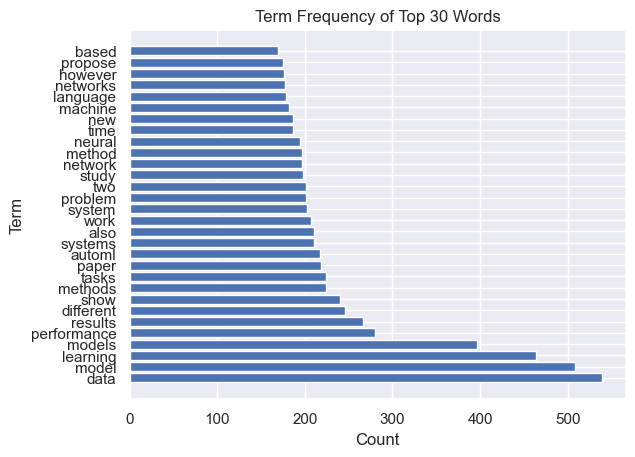

In [23]:
N = 30
plt.clf()
plt.barh(
    term_freq_df.head(N)['term'],
    term_freq_df.head(N)['term_freq']
)
plt.xlabel("Count")
plt.ylabel("Term")
plt.title("Term Frequency of Top {N} Words".format(N = N))
plt.show()

In [24]:
tf_idf = models.TfidfModel(corpus=corpus)

In [31]:
df_body_topics_prob = pd.DataFrame(columns=['topic_'+str(i+1) for i in np.arange(lda.num_topics)])

for index, row in enumerate(lda.get_document_topics(corpus, minimum_probability=0.0)):
    _, prob = zip(*row)
    df_body_topics_prob.loc[index] = list(prob)

In [33]:
topics_df = research_df.reset_index(drop=True).merge(
        df_body_topics_prob, how='left', right_index=True, left_index=True
)

In [34]:
df_body_topics = pd.DataFrame(index = ['topic_' + str(i+1) for i in np.arange(lda.num_topics)])

df_body_topics['n_documents'] = df_body_topics_prob[df_body_topics_prob>0.2].count(axis = 0)
#df_body_topics['coverage'] = df_body_topics_prob.sum(axis = 0)
df_body_topics['keywords'] = [
    ' '.join([word for word, prop in topic[1]]) for topic in lda.show_topics(
        num_topics=lda.num_topics, 
        num_words=50, formatted=False
    )
]

In [35]:
df_body_topics

,n_documents,keywords
topic_1,64,data model models system work also different g...
topic_2,55,model data new models propose methods tracking...
topic_3,73,systems data system solution problem model net...
topic_4,30,inverse data model framework problems function...
topic_5,157,learning models automl performance data search...
topic_6,80,data model study time method show results netw...
topic_7,146,learning data machine automl model models prob...
topic_8,50,data model performance models paper show resul...
topic_9,63,two paper theory model results show system dat...
topic_10,62,model graph training different system network ...


# Supervised Learning - Binary Classification

In [ ]:
# generate labels for topics
# parse labels

In [ ]:
# use labelled data as validation set

## Evaluation

# Supervised Learning - Multi-Class Classification

---